# Add support for STAC Datacube extension

`rio-tiler` supports GDAL and Xarray Based dataset (DataArray) but supporting both together in a STACReader if tricky because a Xarray based reader might need some `reader_options` provider before openning the dataset. 

The goal of this notebook is to show how to create a STAC Reader which support the Datacube extension to avoid maximize the compatibility between all the dataset.

# Requirements

To be able to run this notebook you'll need the following requirements:
- rio-tiler~=7.0
- xarray
- rioxarray
- h5netcdf
- matplotlib

### 1. Simple NetCDF reader

In [4]:
from typing import List

import attr
import xarray
from morecantile import TileMatrixSet
from rio_tiler.io import XarrayReader
from rio_tiler.constants import WEB_MERCATOR_TMS


@attr.s
class NetCDFReader(XarrayReader):
    """Reader: Open NetCDF file and access DataArray."""

    src_path: str = attr.ib()
    variable: str = attr.ib()

    tms: TileMatrixSet = attr.ib(default=WEB_MERCATOR_TMS)

    ds: xarray.Dataset = attr.ib(init=False)
    input: xarray.DataArray = attr.ib(init=False)

    _dims: List = attr.ib(init=False, factory=list)

    def __attrs_post_init__(self):
        """Set bounds and CRS."""
        self.ds = xarray.open_dataset(self.src_path, decode_coords="all")
        da = self.ds[self.variable]

        # Make sure we have a valid CRS
        crs = da.rio.crs or "epsg:4326"
        da = da.rio.write_crs(crs)

        if "time" in da.dims:
            da = da.isel(time=0)

        self.input = da

        super().__attrs_post_init__()

bounds=(-170.085, -80.08, 169.914999999975, 79.91999999999659) crs='http://www.opengis.net/def/crs/EPSG/0/4326' band_metadata=[('b1', {})] band_descriptions=[('b1', 'value')] dtype='float64' nodata_type='Nodata' colorinterp=None scales=None offsets=None colormap=None name='dataset' count=1 width=2000 height=1000 attrs={'valid_min': 1.0, 'valid_max': 1000.0, 'fill_value': 0}


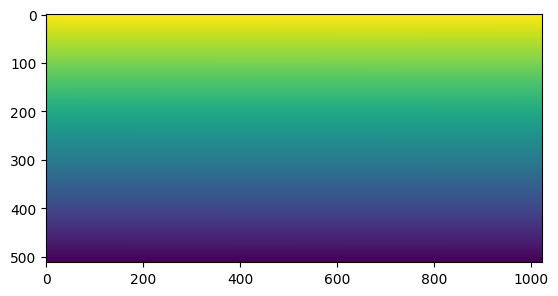

In [5]:
import matplotlib.pyplot as plt

with NetCDFReader("data/dataset_2d.nc", variable="dataset") as src:
    print(src.info())

    # NOTE: We can use the preview method because we know the data is relatively small
    # but don't use this for large dataset stored on the cloud (because it would download the whole data)
    img = src.preview()

plt.imshow(img.data_as_image())

### 2. Custom STAC reader

In [7]:
from typing import Set, Type, Tuple, Dict
from rio_tiler.types import AssetInfo
from rio_tiler.io import STACReader, BaseReader
from rio_tiler.io.stac import STAC_ALTERNATE_KEY

valid_types = {
    "image/tiff; application=geotiff",
    "application/x-netcdf",
}


@attr.s
class CustomSTACReader(STACReader):
    include_asset_types: Set[str] = attr.ib(default=valid_types)

    def get_asset_list(self) -> List[str]:
        """Get valid asset list"""
        include = self.include_assets
        exclude = self.exclude_assets
        include_asset_types = self.include_asset_types
        exclude_asset_types = self.exclude_asset_types

        assets = []
        for asset, asset_info in self.item.get_assets().items():
            _type = asset_info.media_type

            if exclude and asset in exclude:
                continue

            if (
                _type
                and (exclude_asset_types and _type in exclude_asset_types)
                or (include and asset not in include)
            ):
                continue

            if (
                _type
                and (include_asset_types and _type not in include_asset_types)
                or (include and asset not in include)
            ):
                continue

            # Here check for the datacube extension
            extras = asset_info.extra_fields
            if variables := extras.get("cube:variables"):
                assets += [f"{asset}:{v}" for v in list(variables)]
            else:
                assets.append(asset)

        return assets

    def _get_reader(self, asset_info: AssetInfo) -> Tuple[Type[BaseReader], Dict]:
        """Get Asset Reader."""
        asset_type = asset_info.get("media_type", None)
        if asset_type and asset_type in [
            "application/x-netcdf",
        ]:
            return NetCDFReader, asset_info.get("reader_options", {})

        return Reader, asset_info.get("reader_options", {})

    def _get_asset_info(self, asset: str) -> AssetInfo:
        """Validate asset names and return asset's info.

        Args:
            asset (str): STAC asset name.

        Returns:
            AssetInfo: STAC asset info.

        """
        asset, vrt_options = self._parse_vrt_asset(asset)
        if asset not in self.assets:
            raise InvalidAssetName(
                f"'{asset}' is not valid, should be one of {self.assets}"
            )

        variable = None
        if ":" in asset:
            asset, variable = asset.split(":")

        asset_info = self.item.assets[asset]
        extras = asset_info.extra_fields

        info = AssetInfo(
            url=asset_info.get_absolute_href() or asset_info.href,
            metadata=extras if not vrt_options else None,
        )

        if STAC_ALTERNATE_KEY and extras.get("alternate"):
            if alternate := extras["alternate"].get(STAC_ALTERNATE_KEY):
                info["url"] = alternate["href"]

        if asset_info.media_type:
            info["media_type"] = asset_info.media_type

        # https://github.com/stac-extensions/file
        if head := extras.get("file:header_size"):
            info["env"] = {"GDAL_INGESTED_BYTES_AT_OPEN": head}

        # https://github.com/stac-extensions/raster
        if extras.get("raster:bands") and not vrt_options:
            bands = extras.get("raster:bands")
            stats = [
                (b["statistics"]["minimum"], b["statistics"]["maximum"])
                for b in bands
                if {"minimum", "maximum"}.issubset(b.get("statistics", {}))
            ]
            # check that stats data are all double and make warning if not
            if (
                stats
                and all(isinstance(v, (int, float)) for stat in stats for v in stat)
                and len(stats) == len(bands)
            ):
                info["dataset_statistics"] = stats
            else:
                warnings.warn(
                    "Some statistics data in STAC are invalid, they will be ignored."
                )

        if vrt_options:
            info["url"] = f"vrt://{info['url']}?{vrt_options}"

        if variable is not None:
            info["reader_options"] = {"variable": variable}

        return info

CustomSTACReader(bounds=(-170.085, 79.91999999999659, 169.91499999997504, -80.08), crs=CRS.from_epsg(4326), transform=[0.16999999999998752, 0, -170.085, 0, 0.1599999999999966, -80.08, 0, 0, 1], height=1000, width=2000, input='data/stac_netcdf.json', item=<Item id=my_stac>, tms=<TileMatrixSet title='Google Maps Compatible for the World' id='WebMercatorQuad' crs='http://www.opengis.net/def/crs/EPSG/0/3857>, minzoom=0, maxzoom=3, include_assets=None, exclude_assets=None, exclude_asset_types=None, assets=['netcdf:dataset'], default_assets=None, reader=<class 'rio_tiler.io.rasterio.Reader'>, reader_options={}, fetch_options={}, ctx=<class 'rasterio.env.Env'>, include_asset_types={'application/x-netcdf', 'image/tiff; application=geotiff'})
['netcdf:dataset']
{'url': '/Users/vincentsarago/Dev/CogeoTiff/rio-tiler/docs/src/examples/data/dataset_2d.nc', 'metadata': {'cube:variables': {'dataset': {'dimensions': ['y', 'x'], 'type': 'data'}}}, 'media_type': 'application/x-netcdf', 'reader_options':

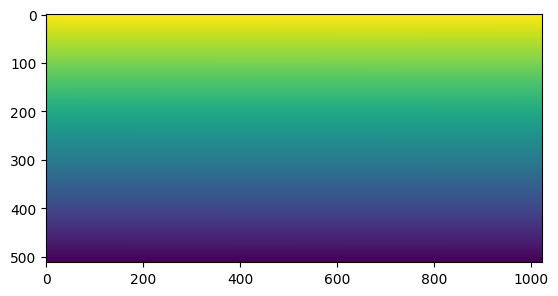

In [8]:
with CustomSTACReader("data/stac_netcdf.json") as src:
    print(src)
    print(src.assets)
    print(src._get_asset_info("netcdf:dataset"))
    img = src.preview(assets=["netcdf:dataset"])

plt.imshow(img.data_as_image())

### 3. Supporting NetCDF without datacube 

YOu can also support `NetCDF` files without the datacube extension by customizing the `_get_asset_info` and `_get_reader`. The customization consist by adding a `asset virtual format` (as we do for VRT) in form of `{asset_name}:{variable_name}`

In [11]:
from typing import Set, Type, Tuple, Dict
from rio_tiler.types import AssetInfo
from rio_tiler.io import STACReader, BaseReader

valid_types = {
    "image/tiff; application=geotiff",
    "application/x-netcdf",
}


@attr.s
class CustomSTACReader(STACReader):
    include_asset_types: Set[str] = attr.ib(default=valid_types)

    def _get_reader(self, asset_info: AssetInfo) -> Tuple[Type[BaseReader], Dict]:
        """Get Asset Reader."""
        asset_type = asset_info.get("media_type", None)
        if asset_type and asset_type in [
            "application/x-netcdf",
        ]:
            return NetCDFReader, asset_info.get("reader_options", {})

        return Reader, asset_info.get("reader_options", {})

    def _get_asset_info(self, asset: str) -> AssetInfo:
        """Validate asset names and return asset's info.

        Args:
            asset (str): STAC asset name.

        Returns:
            AssetInfo: STAC asset info.

        """
        asset, vrt_options = self._parse_vrt_asset(asset)

        # See how this is now before the asset validation
        variable = None
        if ":" in asset:
            asset, variable = asset.split(":")

        if asset not in self.assets:
            raise InvalidAssetName(
                f"'{asset}' is not valid, should be one of {self.assets}"
            )

        asset_info = self.item.assets[asset]
        extras = asset_info.extra_fields

        info = AssetInfo(
            url=asset_info.get_absolute_href() or asset_info.href,
            metadata=extras if not vrt_options else None,
        )

        if STAC_ALTERNATE_KEY and extras.get("alternate"):
            if alternate := extras["alternate"].get(STAC_ALTERNATE_KEY):
                info["url"] = alternate["href"]

        if asset_info.media_type:
            info["media_type"] = asset_info.media_type

        # https://github.com/stac-extensions/file
        if head := extras.get("file:header_size"):
            info["env"] = {"GDAL_INGESTED_BYTES_AT_OPEN": head}

        # https://github.com/stac-extensions/raster
        if extras.get("raster:bands") and not vrt_options:
            bands = extras.get("raster:bands")
            stats = [
                (b["statistics"]["minimum"], b["statistics"]["maximum"])
                for b in bands
                if {"minimum", "maximum"}.issubset(b.get("statistics", {}))
            ]
            # check that stats data are all double and make warning if not
            if (
                stats
                and all(isinstance(v, (int, float)) for stat in stats for v in stat)
                and len(stats) == len(bands)
            ):
                info["dataset_statistics"] = stats
            else:
                warnings.warn(
                    "Some statistics data in STAC are invalid, they will be ignored."
                )

        if vrt_options:
            info["url"] = f"vrt://{info['url']}?{vrt_options}"

        if variable is not None:
            info["reader_options"] = {"variable": variable}

        return info

CustomSTACReader(bounds=(-170.085, 79.91999999999659, 169.91499999997504, -80.08), crs=CRS.from_epsg(4326), transform=[0.16999999999998752, 0, -170.085, 0, 0.1599999999999966, -80.08, 0, 0, 1], height=1000, width=2000, input='data/stac_netcdf.json', item=<Item id=my_stac>, tms=<TileMatrixSet title='Google Maps Compatible for the World' id='WebMercatorQuad' crs='http://www.opengis.net/def/crs/EPSG/0/3857>, minzoom=0, maxzoom=3, include_assets=None, exclude_assets=None, exclude_asset_types=None, assets=['netcdf'], default_assets=None, reader=<class 'rio_tiler.io.rasterio.Reader'>, reader_options={}, fetch_options={}, ctx=<class 'rasterio.env.Env'>, include_asset_types={'application/x-netcdf', 'image/tiff; application=geotiff'})
['netcdf']
{'url': '/Users/vincentsarago/Dev/CogeoTiff/rio-tiler/docs/src/examples/data/dataset_2d.nc', 'metadata': {'cube:variables': {'dataset': {'dimensions': ['y', 'x'], 'type': 'data'}}}, 'media_type': 'application/x-netcdf', 'reader_options': {'variable': 'd

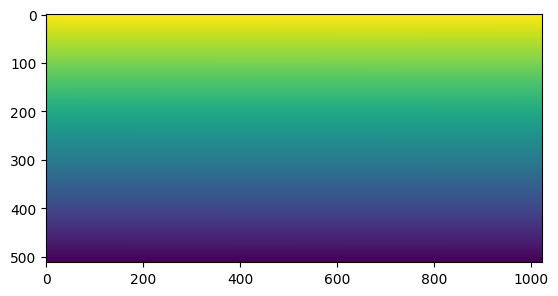

In [12]:
with CustomSTACReader("data/stac_netcdf.json") as src:
    print(src)
    print(src.assets)
    print(src._get_asset_info("netcdf:dataset"))
    img = src.preview(assets=["netcdf:dataset"])

plt.imshow(img.data_as_image())